In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import joblib
from joblib import load
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

from sklearn.ensemble import RandomForestRegressor

from itertools import product


from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold, RandomizedSearchCV
import multiprocessing

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score,roc_auc_score, roc_curve

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterGrid
import sklearn.metrics as metrics

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer

from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

import pickle  # Para cargar el modelo guardado

### (PARENTESIS)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


## 1. Carga de datos

In [3]:

data = pd.read_csv('df_con_grid.csv')


### Crear variables

In [4]:

# Definir la normalización de las variables


#Consideramos que el riesgo aumenta conforme la temperatura se aleja de un valor seguro, 
# por ejemplo, 30°C. A partir de los 40°C ya el riesgo se vuelve muy alto.
def Temperatura_normalizada(temperature):
    return max(0, min(1, (temperature - 30) / (40 - 30)))

#El riesgo de incendio crece cuando la humedad es muy baja. 
# Consideramos que la humedad es más peligrosa por debajo de un 30%.
def Humedad_normalizada(humidity):
    return max(0, min(1, (30 - humidity) / 30))

#La velocidad del viento también tiene un impacto importante. 
# Por ejemplo, un viento superior a 30 km/h puede hacer que un incendio se propague rápidamente.
def Viento_normalizado(wind_speed):
    return max(0, min(1, (wind_speed - 30) / (60 - 30)))

# Crear la nueva variable 'fire_risk_index' con la fórmula ponderada segun la importancia relativa que he considerado 
# donde he dado menos importancia al la velocidad del viendo que las otras dos variables T y H
def calculate_fire_risk(row):
    Temperature = Temperatura_normalizada(row['Temperature (C)']) 
    Humedad = Humedad_normalizada(row['Humidity (%)']) 
    Viento = Viento_normalizado(row['V_VIENTO']) 
    
    # Índice ponderado 30/30/30
    fire_risk_index = 0.4 * Temperature + 0.4 * Humedad + 0.2 * Viento
    
    return fire_risk_index

# Crear la nueva columna en el DataFrame
data['fire_risk_index'] = data.apply(calculate_fire_risk, axis=1)

# Guardar el DataFrame actualizado en un nuevo archivo CSV
output_file = 'df_con_grid_fire.csv'  #
data.to_csv(output_file, index=False)

print(f"Índice de riesgo de incendio calculado y guardado en '{output_file}'")


Índice de riesgo de incendio calculado y guardado en 'df_con_grid_fire.csv'


In [5]:
# Feature 1: 
data['difficulty_viento_humedad'] = data['DifficultyIndex'] * (data['V_VIENTO'] + data['Humidity (%)'])

# Feature 2:
data['fire_risk_fuel'] = data['fire_risk_index'] * (data['FuelLoadIndex'] / 100)

# Feature 3: 
data['fire_risk_landcover'] = data['fire_risk_index'] * data['LandCover']


output_file = 'df_con_grid_fire.csv'  #
data.to_csv(output_file, index=False)

print(f"Índice de riesgo de incendio calculado y guardado en '{output_file}'")

Índice de riesgo de incendio calculado y guardado en 'df_con_grid_fire.csv'


Creo a continuacion las variables de tipo clase para predecir si hay que madar o no aviones, buldozzer o helicopteros

In [6]:

data = pd.read_csv('df_con_grid_fire.csv')

In [7]:


def AvionAnfibio(range_str):
    if range_str == 0:
        return 0
    
    else:
        return 1


data['AVIANFNUM_CLASS'] = data['AVIANFNUM'].apply(AvionAnfibio)

In [8]:
def AvionTerre(range_str):
    if range_str == 0:
        return 0
    
    else:
        return 1


data['AVICARNUM_CLASS'] = data['AVICARNUM'].apply(AvionTerre)

In [9]:
def map_buldozzer(range_str):
    if range_str == 0:
        return 0
    
    else:
        return 1


data['BULDOZZER_CLASS'] = data['BULDOZZER'].apply(map_buldozzer)

data[['BULDOZZER_CLASS', 'BULDOZZER']].value_counts()

BULDOZZER_CLASS  BULDOZZER
0                0            10471
1                1               34
                 2               12
                 3                5
                 25               2
                 5                1
                 10               1
Name: count, dtype: int64

In [10]:
def map_AUTOBOMBA(range_str):
    if range_str == 0:
        return 0
    
    else:
        return 1


data['AUTOBOMBA_CLASS'] = data['AUTOBOMBA'].apply(map_AUTOBOMBA)

## 2. Filtrar datos

Se eliminan los datos que no pertenecen a la comunidad valenciana y que son dependientes de de la longuitud y la latitud.
Alguno de los datos que quedan pueden ser de otra comunidad dado que limitamos en cuadrado y la comunidad valenciana no es un rectangulo si no que tiene entradas y salidad del terreno

In [11]:
data = data.replace({',': ''}, regex=True)



Datos originales: (10526, 168)
Datos filtrados: (10526, 168)


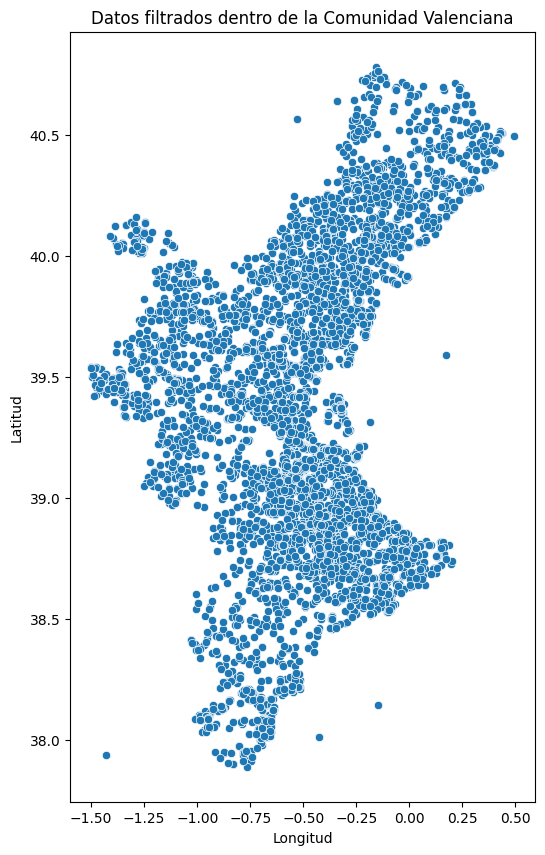

In [12]:
# Se incluyen unicamente los datos que estan dentro de las coordenadas correctas de la comunidad valenciana
data_filtrado = data[
    (data['Latitude'] <= 42) & (data['Latitude'] >= 36) &  # Latitude
    
    (data['Longitude'] <= 0.6) & (data['Longitude'] >= -1.7)  # Longitude
]

print(f"Datos originales: {data.shape}")
print(f"Datos filtrados: {data_filtrado.shape}")

# Gráfico
plt.figure(figsize=(6,10))
sns.scatterplot(data=data_filtrado, x='Longitude', y='Latitude')
plt.title("Datos filtrados dentro de la Comunidad Valenciana")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


# BULDOZZER

In [ ]:

X = data_filtrado[['COMARCA','CS_ELEC','DifficultyIndex','D_APIE','D_VIENTO','DTORMENTA','DULLUVIA',
             'EROSION','ESTACION','Elevation','fire_risk_index', 'FuelLoadIndex','Humidity (%)','HOJA','IND_PEL','LandCover',
             'MOD_COM','PART_ASOC','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_landcover',
             'fire_risk_fuel','difficulty_viento_humedad','BULDOZZER_CLASS']]
y = data_filtrado[ 'BULDOZZER_CLASS']

In [189]:
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

RandomForestClassifier(random_state=42)

Miro la importancia y entonces quito los ultimos que considera que tiene menos importancia para el modelo. Aunque vamos a hacer un Random forest y esto no afecta tanto como en uno lineal, quiro reducir la el tiempo de computo

In [190]:
importance = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance}).sort_values(by='Importance', ascending=False)
print(importance_df)




                      Feature  Importance
9                Humidity (%)    0.115115
1   difficulty_viento_humedad    0.111266
13            Temperature (C)    0.106712
15                          X    0.081345
16                          Y    0.070404
3                    DULLUVIA    0.061566
12                      Slope    0.058954
11                    MOD_COM    0.058937
6         fire_risk_landcover    0.058835
14                   V_VIENTO    0.057023
2                      D_APIE    0.038580
0                     COMARCA    0.037600
7              fire_risk_fuel    0.036073
4                     EROSION    0.030791
5                    ESTACION    0.028918
10                    IND_PEL    0.028226
8               FuelLoadIndex    0.019656


In [191]:
data_imputer = data_filtrado[['COMARCA','CS_ELEC','DifficultyIndex','D_APIE','D_VIENTO','DTORMENTA','DULLUVIA',
             'EROSION','ESTACION','Elevation','fire_risk_index', 'FuelLoadIndex','Humidity (%)','HOJA','IND_PEL','LandCover',
             'MOD_COM','PART_ASOC','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_landcover',
             'fire_risk_fuel','difficulty_viento_humedad','BULDOZZER_CLASS']]

In [192]:


# Define imputer
num_imputer = SimpleImputer(strategy='median')

# Select numerical columns
num_cols = data_imputer.select_dtypes(include=['float64', 'int']).columns

# Transform numerical columns
transformed_array = num_imputer.fit_transform(data_imputer[num_cols])

# Construct a DataFrame for the transformed data
transformed_data = pd.DataFrame(
    transformed_array,
    columns=num_cols,  # Use all selected numerical columns
    index=data_imputer.index  # Maintain original DataFrame index
)

# Assign back to the original DataFrame
data_imputer[num_cols] = transformed_data



/var/folders/mq/qldjlz6d2qnfrl2d278n8dw40000gn/T/ipykernel_866/3042115008.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_imputer[num_cols] = transformed_data


In [193]:
X = data_imputer[['COMARCA','CS_ELEC','DifficultyIndex','D_APIE','D_VIENTO','DTORMENTA','DULLUVIA',
             'EROSION','ESTACION','Elevation','fire_risk_index', 'FuelLoadIndex','Humidity (%)','HOJA','IND_PEL','LandCover',
             'MOD_COM','PART_ASOC','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_landcover',
             'fire_risk_fuel','difficulty_viento_humedad']]
y = data_imputer[ 'BULDOZZER_CLASS']

In [194]:

smotetomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smotetomek.fit_resample(X, y)

# Crear un nuevo DataFrame balanceado
balanced_df = pd.DataFrame(X_resampled, columns=['COMARCA','CS_ELEC','DifficultyIndex','D_APIE','D_VIENTO','DTORMENTA','DULLUVIA',
             'EROSION','ESTACION','Elevation','fire_risk_index', 'FuelLoadIndex','Humidity (%)','HOJA','IND_PEL','LandCover',
             'MOD_COM','PART_ASOC','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_landcover',
             'fire_risk_fuel','difficulty_viento_humedad'])
balanced_df['BULDOZZER_CLASS' ] = y_resampled


In [195]:
# Preparar las características y la variable objetivo
X = balanced_df[['COMARCA','CS_ELEC','DifficultyIndex','D_APIE','D_VIENTO','DTORMENTA','DULLUVIA',
             'EROSION','ESTACION','Elevation','fire_risk_index', 'FuelLoadIndex','Humidity (%)','HOJA','IND_PEL','LandCover',
             'MOD_COM','PART_ASOC','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_landcover',
             'fire_risk_fuel','difficulty_viento_humedad']]
y = balanced_df[ 'BULDOZZER_CLASS']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Random Forest - AUC: 0.9999, Accuracy: 0.9962
XGBoost - AUC: 1.0000, Accuracy: 0.9974
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8350, number of negative: 8344
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6389
[LightGBM] [Info] Number of data points in the train set: 16694, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500180 -> initscore=0.000719
[LightGBM] [Info] Start training from score 0.000719


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:08:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


LightGBM - AUC: 0.9997, Accuracy: 0.9966
CatBoost - AUC: 0.9999, Accuracy: 0.9966


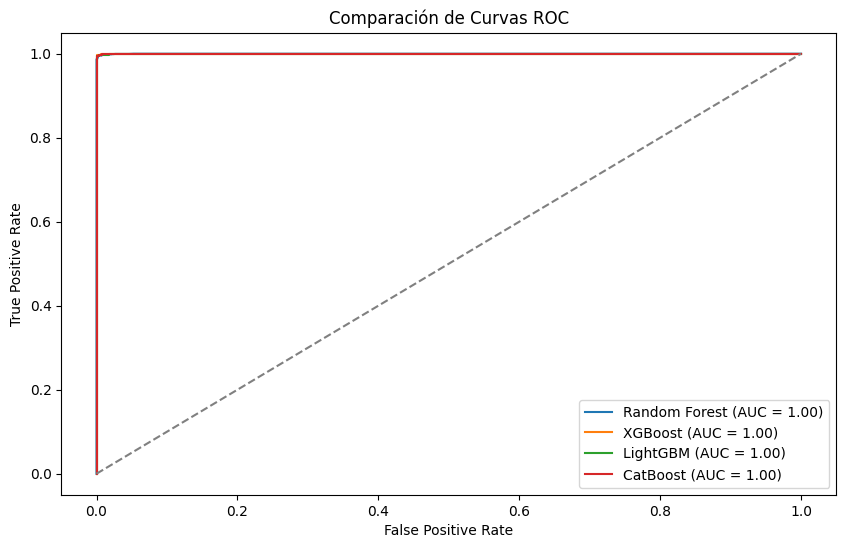

In [196]:

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# Entrenamiento y evaluación
results = {}
for name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Evaluación
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {"AUC": auc, "Accuracy": accuracy}
    
    # Imprimir métricas
    print(f"{name} - AUC: {auc:.4f}, Accuracy: {accuracy:.4f}")

# Comparar las curvas ROC
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['AUC']:.2f})")

# Línea base
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparación de Curvas ROC')
plt.legend()
plt.show()


## 4.Modelos Clasificacion: BULDOZZER

Primero tenemos que saber si necesitamos `1` o no `0` aviones ANFIBIOS DE DESCARGA

In [197]:
# Preparar las características y la variable objetivo
X = balanced_df[['COMARCA','difficulty_viento_humedad','D_APIE','DULLUVIA',
             'EROSION','ESTACION','fire_risk_landcover',
             'fire_risk_fuel', 'FuelLoadIndex','Humidity (%)','IND_PEL',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO', 'X', 'Y']] 
y = balanced_df['BULDOZZER_CLASS']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Comprobar si el modelo es balanceado o no

In [198]:
data_filtrado['BULDOZZER_CLASS'].value_counts().unique

<bound method Series.unique of BULDOZZER_CLASS
0    10471
1       55
Name: count, dtype: int64>

### 4.1. Random forest Classifier 

In [199]:
forest = RandomForestClassifier (random_state=42)

In [200]:
forest.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [201]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(forest.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.9963
Precisión sobre datos de train: 1.0000


In [202]:
# Preparar las características y la variable objetivo
X = data_filtrado[['COMARCA','difficulty_viento_humedad','D_APIE','DULLUVIA',
             'EROSION','ESTACION','fire_risk_landcover',
             'fire_risk_fuel', 'FuelLoadIndex','Humidity (%)','IND_PEL',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO', 'X', 'Y']]
y = data_filtrado[ 'BULDOZZER_CLASS']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

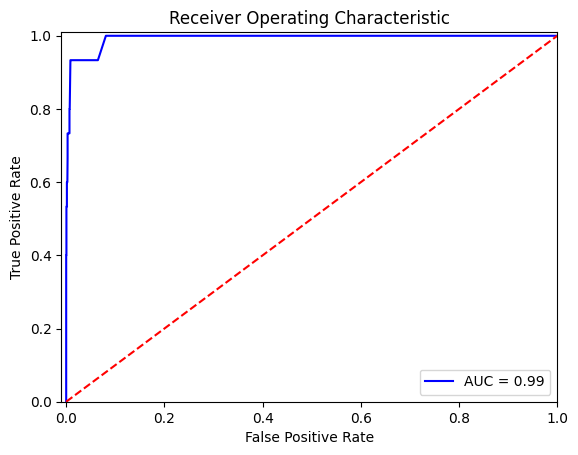

In [203]:
probs = forest.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [204]:
predicciones = forest.predict(X = X_test)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)


Matriz de confusión
[[2088    3]
 [   6    9]]

El accuracy de test es: 99.57264957264957 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2091
           1       0.75      0.60      0.67        15

    accuracy                           1.00      2106
   macro avg       0.87      0.80      0.83      2106
weighted avg       1.00      1.00      1.00      2106



In [205]:
# Preparar las características y la variable objetivo
X = balanced_df[['COMARCA','difficulty_viento_humedad','D_APIE','DULLUVIA',
             'EROSION','ESTACION','fire_risk_landcover',
             'fire_risk_fuel', 'FuelLoadIndex','Humidity (%)','IND_PEL',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO', 'X', 'Y']]
y = balanced_df[ 'BULDOZZER_CLASS']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [206]:
param_range = [30,40,50,60,90,100,130,150,200,300,500]
train_score, test_score= validation_curve(
                                forest,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [63]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 30 en test:',test_score[0].mean(),'en train:',train_score[0].mean())
print ('n_estimators 40 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 50 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 60 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 90 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 100 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 130 en test:',test_score[6].mean(),'en train:',train_score[6].mean())
print ('n_estimators 150 en test:',test_score[7].mean(),'en train:',train_score[7].mean())
print ('n_estimators 200 en test:',test_score[8].mean(),'en train:',train_score[8].mean())
print ('n_estimators 300 en test:',test_score[9].mean(),'en train:',train_score[9].mean())
print ('n_estimators 500 en test:',test_score[10].mean(),'en train:',train_score[10].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 30 en test: 0.9964674422480989 en train: 0.9999700643616226
n_estimators 40 en test: 0.9966470650438124 en train: 1.0
n_estimators 50 en test: 0.9967069452833334 en train: 1.0
n_estimators 60 en test: 0.9967667717543064 en train: 1.0
n_estimators 90 en test: 0.9967068915147854 en train: 1.0
n_estimators 100 en test: 0.996886514310499 en train: 1.0
n_estimators 130 en test: 0.996826634070978 en train: 1.0
n_estimators 150 en test: 0.996826634070978 en train: 1.0
n_estimators 200 en test: 0.996886514310499 en train: 1.0
n_estimators 300 en test: 0.997126035268583 en train: 1.0
n_estimators 500 en test: 0.99694639455002 en train: 1.0


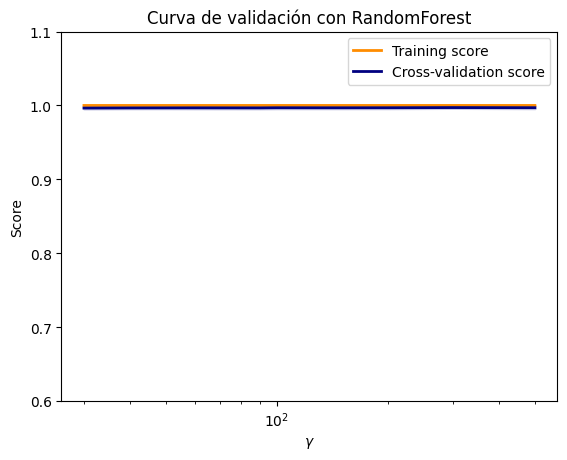

In [64]:
train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)
test_scores_std = np.std(test_score, axis=1)

plt.title("Curva de validación con RandomForest")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.6, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [267]:
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 200, num = 30)]

# Numero de caracteristicas proporcionadas a cada arbol
max_features = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
max_features.append('auto')

# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimo valor para separar en subnodos
min_samples_split = [2, 5, 8, 10]

# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [1, 2 ,3, 4, 5]

# Numero maximo de nodos finales
max_leaf_nodes = [int(x) for x in np.linspace(10, 100, num = 90)]
max_leaf_nodes.append(None)

# Cuadricula
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               "max_leaf_nodes": max_leaf_nodes}


In [268]:
forest_random = RandomizedSearchCV(estimator = forest, 
                                   param_distributions = param_grid, 
                                   n_iter = 30, 
                                   cv = 5, 
                                   scoring='roc_auc',
                                   verbose=1, 
                                   random_state=42, 
                                   n_jobs = 1)


In [269]:
forest_random.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         'auto'],
                                        'max_leaf_nodes': [10, 11, 12, 13, 14,
                                                           15, 16, 17, 18, 19,
                                                           20, 21, 22, 23, 24,
                                                           25, 26, 27, 28, 29,
                                                           30, 31, 32, 33, 34,
                                                           35, 36, 37, 38, 39, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 5, 8, 10],
                                        'n_estimators': [30, 35, 41, 47, 53, 59,
                                                         65, 71, 76, 82, 88, 94,
                                                         100, 106, 112, 117,
                                                         123, 129, 135, 141,
                                                         147, 153, 158, 164,
                                                         170, 176, 182, 188,
                                                         194, 200]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [270]:
best_forest = forest_random.best_estimator_

<BarContainer object of 19 artists>

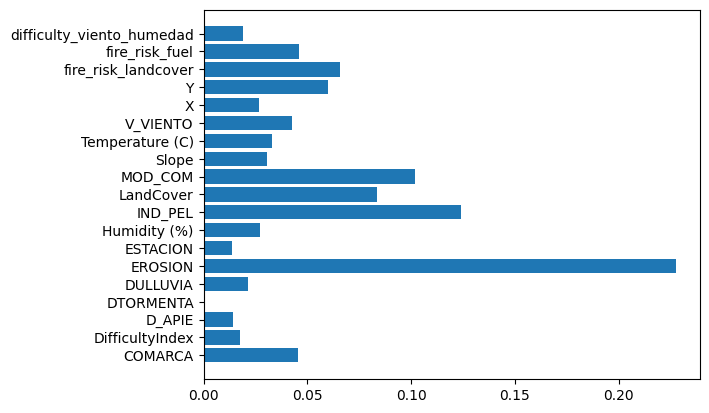

In [271]:
plt.barh(X.columns, best_forest.feature_importances_)

In [207]:
# Preparar las características y la variable objetivo
X = data_filtrado[['COMARCA','difficulty_viento_humedad','D_APIE','DULLUVIA',
             'EROSION','ESTACION','fire_risk_landcover',
             'fire_risk_fuel', 'FuelLoadIndex','Humidity (%)','IND_PEL',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO', 'X', 'Y']]
y = data_filtrado[ 'BULDOZZER_CLASS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [276]:
best_forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=60, max_features=4, max_leaf_nodes=86,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=158, random_state=42)

In [277]:
print('BALANCED_ BEST_PARAMS_')

print("Precisión sobre datos de pruebas: {:.4f}"
      .format(best_forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(best_forest.score(X_train, y_train)))

BALANCED_ BEST_PARAMS_
Precisión sobre datos de pruebas: 0.9929
Precisión sobre datos de train: 0.9954


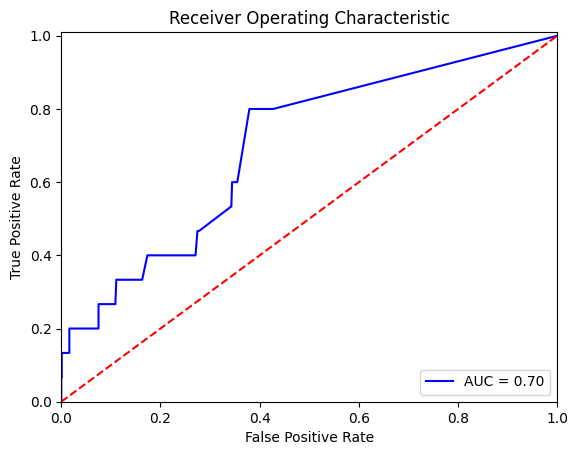

In [278]:
probs = best_forest.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [279]:
predicciones = best_forest.predict(X = X_test)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)


Matriz de confusión
[[2091    0]
 [  15    0]]

El accuracy de test es: 99.28774928774928 %
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2091
           1       0.00      0.00      0.00        15

    accuracy                           0.99      2106
   macro avg       0.50      0.50      0.50      2106
weighted avg       0.99      0.99      0.99      2106



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [208]:
#Rango umbrales en pasos pequeños
thresholds = np.arange(0.1, 1.0, 0.1)
precisions = []
recalls = []
f1_scores = []

# Metricas por umbral
for threshold in thresholds:
    y_pred_adjusted = (preds >= threshold).astype(int)  # Aplicar el umbral
    precisions.append(precision_score(y_test, y_pred_adjusted))
    recalls.append(recall_score(y_test, y_pred_adjusted))
    f1_scores.append(f1_score(y_test, y_pred_adjusted))

# resultados
for i, threshold in enumerate(thresholds):
    print(f"Umbral: {threshold:.1f}, Precision: {precisions[i]:.4f}, Recall: {recalls[i]:.4f}, F1-score: {f1_scores[i]:.4f}")

Umbral: 0.1, Precision: 0.1474, Recall: 0.9333, F1-score: 0.2545
Umbral: 0.2, Precision: 0.3182, Recall: 0.9333, F1-score: 0.4746
Umbral: 0.3, Precision: 0.4783, Recall: 0.7333, F1-score: 0.5789
Umbral: 0.4, Precision: 0.6471, Recall: 0.7333, F1-score: 0.6875
Umbral: 0.5, Precision: 0.7500, Recall: 0.6000, F1-score: 0.6667
Umbral: 0.6, Precision: 0.8000, Recall: 0.5333, F1-score: 0.6400
Umbral: 0.7, Precision: 1.0000, Recall: 0.3333, F1-score: 0.5000
Umbral: 0.8, Precision: 1.0000, Recall: 0.3333, F1-score: 0.5000
Umbral: 0.9, Precision: 1.0000, Recall: 0.1333, F1-score: 0.2353


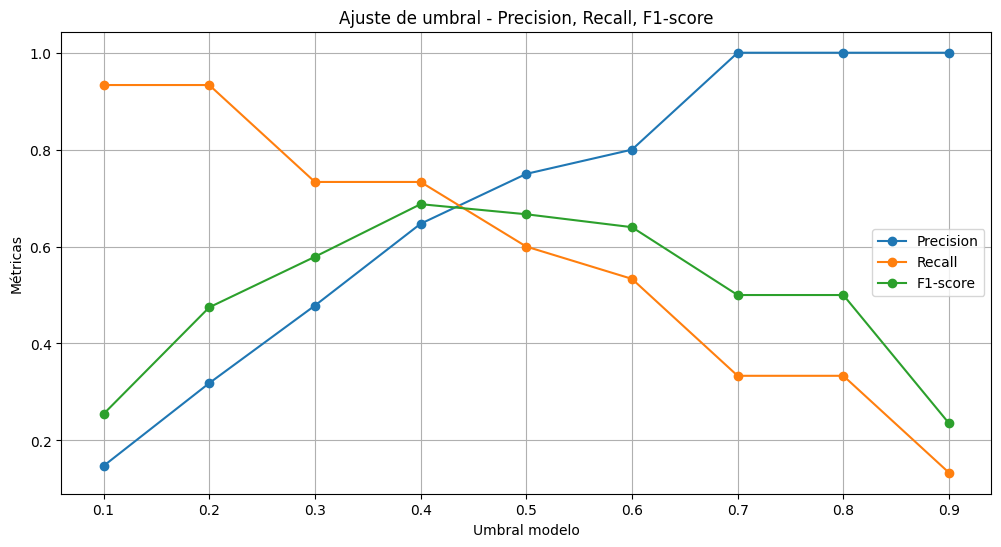

In [210]:
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1-score', marker='o')
plt.xlabel('Umbral modelo')
plt.ylabel('Métricas')
plt.title('Ajuste de umbral - Precision, Recall, F1-score')
plt.legend()
plt.grid(True)
plt.show()


In [212]:
# Coste de un falso positivo (enviar un avión innecesariamente)
cost_fp = 67.80*15  # Coste de enviar un avión segun los datos que tenemos en la introducción de coste hora.
# pongo un *15 porque es la media de las 3 provincias en la comunidad valenciana 

# Estimación del coste de un falso negativo (no enviar un avión cuando es necesario)
cost_fn = (6343*0.07) # Un valor extraido de las hectarias mediana (medias muy altas) quemadas en los datos obtenidos 
#y el coste medio de perdida medio ambiental segúnhttps://evenor-tech.com/el-coste-economico-de-los-incendios-forestales/

thresholds = np.arange(0.1, 1.0, 0.1)
total_costs = []

for threshold in thresholds:
    # Aplicar el umbral para hacer las predicciones ajustadas
    y_pred_adjusted = (preds >= threshold).astype(int)
    
    # Calculoo FP y FN
    false_positive = ((y_pred_adjusted == 1) & (y_test == 0)).sum()
    false_negative = ((y_pred_adjusted == 0) & (y_test == 1)).sum()

    # Coste total
    total_cost = (false_positive * cost_fp) + (false_negative * cost_fn)
    total_costs.append(total_cost)


for i, threshold in enumerate(thresholds):
    print(f"Umbral: {threshold:.1f}, Coste total: {total_costs[i]:.2f} €")

Umbral: 0.1, Coste total: 82821.01 €
Umbral: 0.2, Coste total: 30954.01 €
Umbral: 0.3, Coste total: 13980.04 €
Umbral: 0.4, Coste total: 7878.04 €
Umbral: 0.5, Coste total: 5715.06 €
Umbral: 0.6, Coste total: 5142.07 €
Umbral: 0.7, Coste total: 4440.10 €
Umbral: 0.8, Coste total: 4440.10 €
Umbral: 0.9, Coste total: 5772.13 €


In [213]:
# Ajuste umbral
threshold = 0.4
y_pred_adjusted = (preds  >= threshold).astype(int)

In [214]:
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )


print(confusion_matrix(y_test, y_pred_adjusted))
print(f"El accuracy de test es: {100 * accuracy} %")
print(classification_report(y_test, y_pred_adjusted))


[[2085    6]
 [   4   11]]
El accuracy de test es: 99.57264957264957 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2091
           1       0.65      0.73      0.69        15

    accuracy                           1.00      2106
   macro avg       0.82      0.87      0.84      2106
weighted avg       1.00      1.00      1.00      2106



In [215]:
filename = '../Modelos/buldozzer/best_forest_Buldozzer.pkl'

In [216]:
model_and_threshold = {
    'model': best_cat,
    'threshold': threshold}

    
joblib.dump(model_and_threshold, filename)

['../Modelos/buldozzer/best_forest_Buldozzer.pkl']

### 4.2 Gradient Boosting

In [223]:
# Preparar las características y la variable objetivo
X = balanced_df[['COMARCA','difficulty_viento_humedad','D_APIE','DULLUVIA',
             'EROSION','ESTACION','fire_risk_landcover',
             'fire_risk_fuel', 'FuelLoadIndex','Humidity (%)','IND_PEL',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO', 'X', 'Y']]
y = balanced_df[ 'BULDOZZER_CLASS']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [224]:
lgb_clf =lgb.LGBMClassifier(random_state=42)

In [225]:
lgb_clf.fit(X_train,y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8350, number of negative: 8344
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 16694, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500180 -> initscore=0.000719
[LightGBM] [Info] Start training from score 0.000719


LGBMClassifier(random_state=42)

In [226]:

importance = lgb_clf.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance}).sort_values(by='Importance', ascending=False)
print(importance_df)


                      Feature  Importance
11                    MOD_COM         290
10                    IND_PEL         255
4                     EROSION         241
13            Temperature (C)         199
12                      Slope         198
16                          Y         196
0                     COMARCA         181
9                Humidity (%)         178
15                          X         177
8               FuelLoadIndex         175
3                    DULLUVIA         156
1   difficulty_viento_humedad         155
14                   V_VIENTO         152
5                    ESTACION         143
6         fire_risk_landcover         122
2                      D_APIE         114
7              fire_risk_fuel          68


Tengo error que no me permite el poder hacer le modelo por lo tanto lo que hago es intentar anular ese error haciendo que los objetos se conviertan en int o float

In [227]:

object_columns = X_train.select_dtypes(include=['object']).columns
print("Columnas con dtype object:", object_columns)

# Convertir a numérico (si los valores son realmente números)
for col in object_columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

print(X_train.dtypes)

Columnas con dtype object: Index([], dtype='object')
COMARCA                      float64
difficulty_viento_humedad    float64
D_APIE                       float64
DULLUVIA                     float64
EROSION                      float64
ESTACION                     float64
fire_risk_landcover          float64
fire_risk_fuel               float64
FuelLoadIndex                float64
Humidity (%)                 float64
IND_PEL                      float64
MOD_COM                      float64
Slope                        float64
Temperature (C)              float64
V_VIENTO                     float64
X                            float64
Y                            float64
dtype: object


In [228]:
lgb_clf.fit(X_train,y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8350, number of negative: 8344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 16694, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500180 -> initscore=0.000719
[LightGBM] [Info] Start training from score 0.000719


LGBMClassifier(random_state=42)

In [229]:
# Preparar las características y la variable objetivo
X = data_filtrado[['COMARCA','difficulty_viento_humedad','D_APIE','DULLUVIA',
             'EROSION','ESTACION','fire_risk_landcover',
             'fire_risk_fuel', 'FuelLoadIndex','Humidity (%)','IND_PEL',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO', 'X', 'Y']]
y = data_filtrado[ 'BULDOZZER_CLASS']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [230]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(lgb_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(lgb_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.9972
Precisión sobre el juego de train: 0.9979


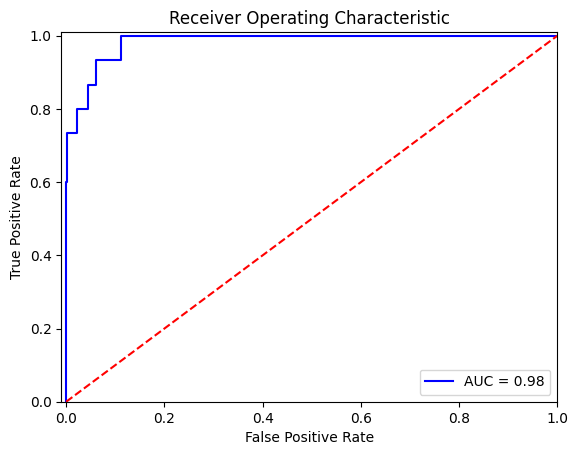

In [231]:
probs = lgb_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [233]:
predicciones = lgb_clf.predict(X = X_test)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)


Matriz de confusión
[[2091    0]
 [   6    9]]

El accuracy de test es: 99.71509971509973 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2091
           1       1.00      0.60      0.75        15

    accuracy                           1.00      2106
   macro avg       1.00      0.80      0.87      2106
weighted avg       1.00      1.00      1.00      2106



In [234]:
# Preparar las características y la variable objetivo
X = balanced_df[['COMARCA','difficulty_viento_humedad','D_APIE','DULLUVIA',
             'EROSION','ESTACION','fire_risk_landcover',
             'fire_risk_fuel', 'FuelLoadIndex','Humidity (%)','IND_PEL',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO', 'X', 'Y']]
y = balanced_df[ 'BULDOZZER_CLASS']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [334]:
param_range = [20,60,90,100,150,200,250,300,400,500]
train_score, test_score= validation_curve(
                                lgb_clf,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 32, number of negative: 6704
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2608
[LightGBM] [Info] Number of data points in the train set: 6736, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004751 -> initscore=-5.344724
[LightGBM] [Info] Start training from score -5.344724
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 32, number of negative: 6704
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=t

In [335]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 10 en test:',test_score[0].mean(),'en train :',train_score[0].mean())
print ('n_estimators 60 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 90 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 100 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 150 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 200 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 250 en test:',test_score[6].mean(),'en train:',train_score[6].mean())
print ('n_estimators 300 en test:',test_score[7].mean(),'en train:',train_score[7].mean())
print ('n_estimators 400 en test:',test_score[8].mean(),'en train:',train_score[8].mean())
print ('n_estimators 500 en test:',test_score[9].mean(),'en train:',train_score[9].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 10 en test: 0.9950118764845606 en train : 1.0
n_estimators 60 en test: 0.9952494061757718 en train: 1.0
n_estimators 90 en test: 0.9952494061757718 en train: 1.0
n_estimators 100 en test: 0.9952494061757718 en train: 1.0
n_estimators 150 en test: 0.9951306413301662 en train: 1.0
n_estimators 200 en test: 0.9951306413301662 en train: 1.0
n_estimators 250 en test: 0.9951306413301662 en train: 1.0
n_estimators 300 en test: 0.9951306413301662 en train: 1.0
n_estimators 400 en test: 0.9951306413301662 en train: 1.0
n_estimators 500 en test: 0.9951306413301662 en train: 1.0


In [336]:
boosting_type = ['gbdt','dart']
#Numero de Hojas máximas por árboles
num_leaves = [int(x) for x in np.linspace(30, 110, num = 9)]

# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

#Learning rate
learning_rate = [round (float(x), 2) for x in np.linspace(0.1, 1., num = 10)]
learning_rate.append(0.005)
learning_rate = sorted(learning_rate)

# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 50)]

# Número de muestras para la construcción de contenedores
subsample_for_bin =  list(range(20000, 300000, 20000))

# Reducción mínima de pérdidas para realizar una nueva partición en un nodo del árbol.
min_split_gain =  [0.0,0.2,0.4,0.6,0.8]

#Número mínimo de datos necesarios en una hoja
min_child_samples = [int(x) for x in np.linspace(1, 40, num = 10)]

# reg_alpha
reg_alpha = [round (float(x), 2) for x in np.linspace(0.0, 1., num = 11)]
# reg_lambda
reg_lambda = [round (float(x), 2)  for x in np.linspace(0.0, 1., num = 11)]
# Creacion de cuadrícula aleatoria
param_grid = {'boosting_type':boosting_type,
              'num_leaves': num_leaves,
              'max_depth': max_depth,
              'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'subsample_for_bin': subsample_for_bin,
              'min_split_gain': min_split_gain,
              'min_child_samples':min_child_samples,
              'reg_alpha':reg_alpha,
              'reg_lambda':reg_lambda}
print(param_grid)

{'boosting_type': ['gbdt', 'dart'], 'num_leaves': [30, 40, 50, 60, 70, 80, 90, 100, 110], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'learning_rate': [0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [100, 108, 116, 124, 132, 140, 148, 157, 165, 173, 181, 189, 197, 206, 214, 222, 230, 238, 246, 255, 263, 271, 279, 287, 295, 304, 312, 320, 328, 336, 344, 353, 361, 369, 377, 385, 393, 402, 410, 418, 426, 434, 442, 451, 459, 467, 475, 483, 491, 500], 'subsample_for_bin': [20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000], 'min_split_gain': [0.0, 0.2, 0.4, 0.6, 0.8], 'min_child_samples': [1, 5, 9, 14, 18, 22, 27, 31, 35, 40], 'reg_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'reg_lambda': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}


In [337]:
light_gbm_random = RandomizedSearchCV(estimator = lgb_clf, 
                                   param_distributions = param_grid, 
                                   n_iter = 50, 
                                   cv = 5, 
                                   scoring='roc_auc',
                                   verbose=1, 
                                   random_state=42, 
                                   n_jobs = 1)

In [338]:
light_gbm_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 32, number of negative: 6704
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2608
[LightGBM] [Info] Number of data points in the train set: 6736, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004751 -> initscore=-5.344724
[LightGBM] [Info] Start training from score -5.344724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

Exception ignored on calling ctypes callback function: <function _log_callback at 0x139c74900>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

KeyboardInterrupt: 

In [ ]:
light_gbm_random.best_params_

{'subsample_for_bin': 220000,
 'reg_lambda': 0.7,
 'reg_alpha': 0.3,
 'num_leaves': 110,
 'n_estimators': 181,
 'min_split_gain': 0.0,
 'min_child_samples': 40,
 'max_depth': 50,
 'learning_rate': 0.9,
 'boosting_type': 'dart'}

In [ ]:
best_light_gbm = light_gbm_random.best_estimator_

<BarContainer object of 19 artists>

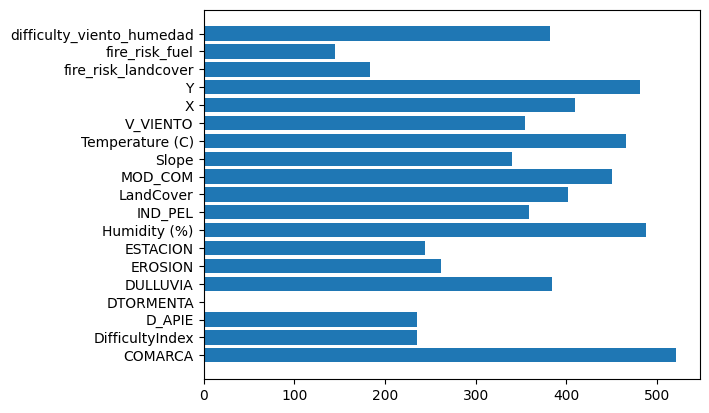

In [ ]:
plt.barh(X.columns, best_light_gbm.feature_importances_)

In [235]:
# Preparar las características y la variable objetivo
X = data_filtrado[['COMARCA','DifficultyIndex','D_APIE','DTORMENTA','DULLUVIA',
             'EROSION','ESTACION','Humidity (%)','IND_PEL','LandCover',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_landcover',
             'fire_risk_fuel','difficulty_viento_humedad']]
y = data_filtrado[ 'BULDOZZER_CLASS']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [302]:
best_light_gbm.fit(X_train,y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 40, number of negative: 8380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2618
[LightGBM] [Info] Number of data points in the train set: 8420, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004751 -> initscore=-5.344724
[LightGBM] [Info] Start training from score -5.344724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMClassifier(boosting_type='dart', learning_rate=0.9, max_depth=50,
               min_child_samples=40, n_estimators=181, num_leaves=110,
               random_state=42, reg_alpha=0.3, reg_lambda=0.7,
               subsample_for_bin=220000)

In [303]:
print('BALANCED_ BEST_PARAMS_')

print("Precisión sobre el juego de test: {:.4f}"
      .format(best_light_gbm.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(best_light_gbm.score(X_train, y_train)))

BALANCED_ BEST_PARAMS_
Precisión sobre el juego de test: 0.9915
Precisión sobre el juego de train: 0.9998


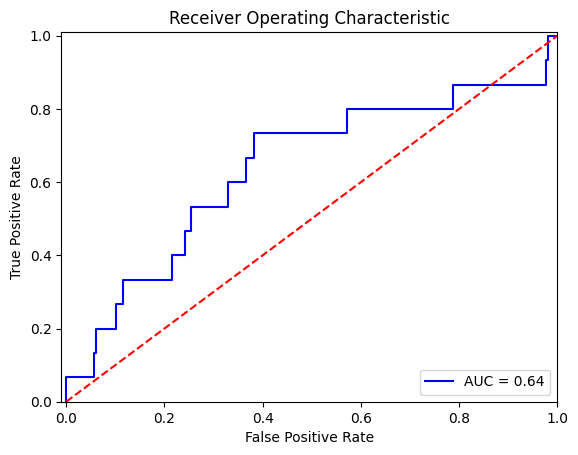

In [706]:
probs = best_light_gbm.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [305]:
predicciones = best_light_gbm.predict(X = X_test)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)

Matriz de confusión
[[2086    5]
 [  13    2]]

El accuracy de test es: 99.14529914529915 %
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2091
           1       0.29      0.13      0.18        15

    accuracy                           0.99      2106
   macro avg       0.64      0.57      0.59      2106
weighted avg       0.99      0.99      0.99      2106



In [236]:
#Rango umbrales en pasos pequeños
thresholds = np.arange(0.1, 1.0, 0.1)
precisions = []
recalls = []
f1_scores = []

# Metricas por umbral
for threshold in thresholds:
    y_pred_adjusted = (preds >= threshold).astype(int)  # Aplicar el umbral
    precisions.append(precision_score(y_test, y_pred_adjusted))
    recalls.append(recall_score(y_test, y_pred_adjusted))
    f1_scores.append(f1_score(y_test, y_pred_adjusted))

# resultados
for i, threshold in enumerate(thresholds):
    print(f"Umbral: {threshold:.1f}, Precision: {precisions[i]:.4f}, Recall: {recalls[i]:.4f}, F1-score: {f1_scores[i]:.4f}")

Umbral: 0.1, Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Umbral: 0.2, Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Umbral: 0.3, Precision: 1.0000, Recall: 0.6000, F1-score: 0.7500
Umbral: 0.4, Precision: 1.0000, Recall: 0.6000, F1-score: 0.7500
Umbral: 0.5, Precision: 1.0000, Recall: 0.6000, F1-score: 0.7500
Umbral: 0.6, Precision: 1.0000, Recall: 0.5333, F1-score: 0.6957
Umbral: 0.7, Precision: 1.0000, Recall: 0.4000, F1-score: 0.5714
Umbral: 0.8, Precision: 1.0000, Recall: 0.2667, F1-score: 0.4211
Umbral: 0.9, Precision: 1.0000, Recall: 0.2667, F1-score: 0.4211


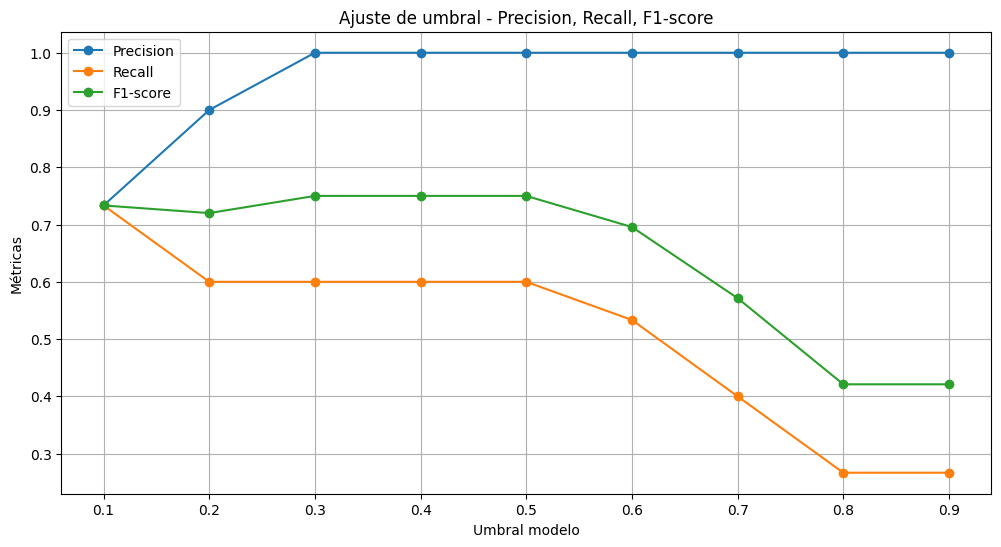

In [237]:
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1-score', marker='o')
plt.xlabel('Umbral modelo')
plt.ylabel('Métricas')
plt.title('Ajuste de umbral - Precision, Recall, F1-score')
plt.legend()
plt.grid(True)
plt.show()


In [238]:
# Coste de un falso positivo (enviar un avión innecesariamente)
cost_fp = 67.80*15  # Coste de enviar un avión segun los datos que tenemos en la introducción de coste hora.
# pongo un *15 porque es la media de las 3 provincias en la comunidad valenciana 

# Estimación del coste de un falso negativo (no enviar un avión cuando es necesario)
cost_fn = (6343*0.07) # Un valor extraido de las hectarias mediana (medias muy altas) quemadas en los datos obtenidos 
#y el coste medio de perdida medio ambiental segúnhttps://evenor-tech.com/el-coste-economico-de-los-incendios-forestales/

thresholds = np.arange(0.1, 1.0, 0.1)
total_costs = []

for threshold in thresholds:
    # Aplicar el umbral para hacer las predicciones ajustadas
    y_pred_adjusted = (preds >= threshold).astype(int)
    
    # Calculoo FP y FN
    false_positive = ((y_pred_adjusted == 1) & (y_test == 0)).sum()
    false_negative = ((y_pred_adjusted == 0) & (y_test == 1)).sum()

    # Coste total
    total_cost = (false_positive * cost_fp) + (false_negative * cost_fn)
    total_costs.append(total_cost)


for i, threshold in enumerate(thresholds):
    print(f"Umbral: {threshold:.1f}, Coste total: {total_costs[i]:.2f} €")

Umbral: 0.1, Coste total: 5844.04 €
Umbral: 0.2, Coste total: 3681.06 €
Umbral: 0.3, Coste total: 2664.06 €
Umbral: 0.4, Coste total: 2664.06 €
Umbral: 0.5, Coste total: 2664.06 €
Umbral: 0.6, Coste total: 3108.07 €
Umbral: 0.7, Coste total: 3996.09 €
Umbral: 0.8, Coste total: 4884.11 €
Umbral: 0.9, Coste total: 4884.11 €


In [239]:
# Ajuste umbral
threshold = 0.1
y_pred_adjusted = (preds  >= threshold).astype(int)

In [241]:
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )


print(confusion_matrix(y_test, y_pred_adjusted))
print(f"El accuracy de test es: {100 * accuracy} %")
print(classification_report(y_test, y_pred_adjusted))


[[2087    4]
 [   4   11]]
El accuracy de test es: 99.71509971509973 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2091
           1       0.73      0.73      0.73        15

    accuracy                           1.00      2106
   macro avg       0.87      0.87      0.87      2106
weighted avg       1.00      1.00      1.00      2106



In [242]:
filename = '../Modelos/buldozzer/best_lgb_Buldozzer.pkl'

In [243]:
model_and_threshold = {
    'model': best_cat,
    'threshold': threshold}

    
joblib.dump(model_and_threshold, filename)

['../Modelos/buldozzer/best_lgb_Buldozzer.pkl']

### 4.3 Cat Boosting

In [244]:
X = balanced_df[['COMARCA','difficulty_viento_humedad','D_APIE','DULLUVIA',
             'EROSION','ESTACION','fire_risk_landcover',
             'fire_risk_fuel', 'FuelLoadIndex','Humidity (%)','IND_PEL',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO', 'X', 'Y']]
y = balanced_df[ 'BULDOZZER_CLASS']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [245]:
catboost_model = CatBoostClassifier(iterations=1000, 
                                    learning_rate=0.1, 
                                    depth=6, 
                                    verbose=200,
                                    random_state=42)

In [246]:
catboost_model.fit(X_train, y_train)

0:	learn: 0.5559937	total: 3.67ms	remaining: 3.66s
200:	learn: 0.0052753	total: 506ms	remaining: 2.01s
400:	learn: 0.0030620	total: 922ms	remaining: 1.38s
600:	learn: 0.0027553	total: 1.3s	remaining: 862ms
800:	learn: 0.0027031	total: 1.69s	remaining: 421ms
999:	learn: 0.0026712	total: 2.4s	remaining: 0us


In [247]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(catboost_model.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(catboost_model.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.9971
Precisión sobre el juego de train: 0.9999


In [248]:
# Preparar las características y la variable objetivo
X = data_filtrado[['COMARCA','difficulty_viento_humedad','D_APIE','DULLUVIA',
             'EROSION','ESTACION','fire_risk_landcover',
             'fire_risk_fuel', 'FuelLoadIndex','Humidity (%)','IND_PEL',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO', 'X', 'Y']]
y = data_filtrado[ 'BULDOZZER_CLASS']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

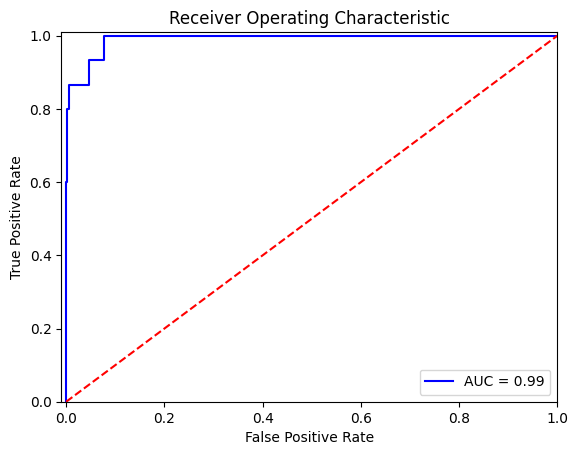

In [249]:
probs = catboost_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [250]:
predicciones = catboost_model.predict(X_test)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)


Matriz de confusión
[[2091    0]
 [  10    5]]

El accuracy de test es: 99.52516619183285 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2091
           1       1.00      0.33      0.50        15

    accuracy                           1.00      2106
   macro avg       1.00      0.67      0.75      2106
weighted avg       1.00      1.00      0.99      2106



In [313]:

param_grid = {
    'iterations': [100, 200, 300, 500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'l2_leaf_reg': [1, 3, 5, 10],  
    'border_count': [32, 64, 128]
}

In [314]:
cat_random = RandomizedSearchCV(estimator = catboost_model, 
                                   param_distributions = param_grid, 
                                   n_iter = 50, 
                                   cv = 5, 
                                   scoring='roc_auc',
                                   verbose=1, 
                                   random_state=42, 
                                   n_jobs = 1)

In [315]:
# Preparar las características y la variable objetivo
X = balanced_df[['COMARCA','DifficultyIndex','D_APIE','DTORMENTA','DULLUVIA',
             'EROSION','ESTACION','Humidity (%)','IND_PEL','LandCover',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_landcover',
             'fire_risk_fuel','difficulty_viento_humedad']]
y = balanced_df[ 'BULDOZZER_CLASS']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [316]:
cat_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0:	learn: 0.6777671	total: 6.18ms	remaining: 1.85s
200:	learn: 0.0667751	total: 782ms	remaining: 385ms
299:	learn: 0.0400570	total: 1.13s	remaining: 0us
0:	learn: 0.6775713	total: 4.16ms	remaining: 1.24s
200:	learn: 0.0659666	total: 704ms	remaining: 347ms
299:	learn: 0.0392351	total: 1.04s	remaining: 0us
0:	learn: 0.6771456	total: 3.75ms	remaining: 1.12s
200:	learn: 0.0677068	total: 714ms	remaining: 352ms
299:	learn: 0.0393887	total: 1.05s	remaining: 0us
0:	learn: 0.6758429	total: 4.04ms	remaining: 1.21s
200:	learn: 0.0683654	total: 725ms	remaining: 357ms
299:	learn: 0.0411893	total: 1.07s	remaining: 0us
0:	learn: 0.6773067	total: 3.61ms	remaining: 1.08s
200:	learn: 0.0654610	total: 691ms	remaining: 340ms
299:	learn: 0.0389180	total: 1.03s	remaining: 0us
0:	learn: 0.6390213	total: 1.92ms	remaining: 1.92s
200:	learn: 0.0166507	total: 406ms	remaining: 1.61s
400:	learn: 0.0088316	total: 784ms	remaining: 1.17s
600:	learn: 0.0065

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x169cceb40>,
                   n_iter=50, n_jobs=1,
                   param_distributions={'border_count': [32, 64, 128],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [100, 200, 300, 500,
                                                       1000],
                                        'l2_leaf_reg': [1, 3, 5, 10],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.15]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [317]:
best_cat = cat_random.best_estimator_

<BarContainer object of 19 artists>

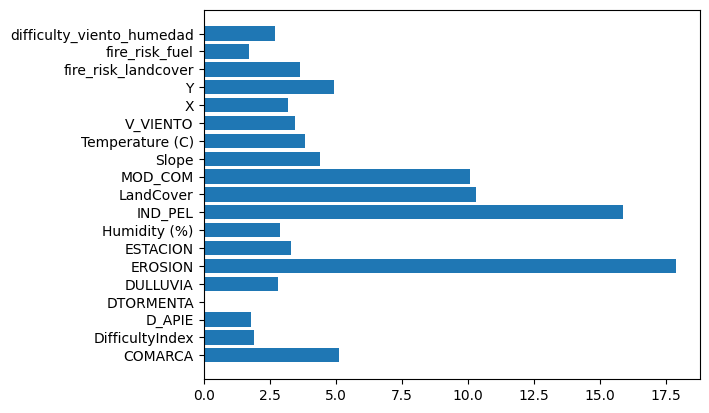

In [318]:
plt.barh(X.columns, best_cat.feature_importances_)

In [319]:
# Preparar las características y la variable objetivo
X = data_filtrado[['COMARCA','DifficultyIndex','D_APIE','DTORMENTA','DULLUVIA',
             'EROSION','ESTACION','Humidity (%)','IND_PEL','LandCover',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO','X','Y','fire_risk_landcover',
             'fire_risk_fuel','difficulty_viento_humedad']]
y = data_filtrado[ 'BULDOZZER_CLASS']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [320]:
best_cat.fit(X_train,y_train)

0:	learn: 0.5640468	total: 5.95ms	remaining: 1.78s
200:	learn: 0.0014625	total: 858ms	remaining: 422ms
299:	learn: 0.0007997	total: 1.25s	remaining: 0us


In [321]:
print('BALANCED_ BEST_PARAMS_')

print("Precisión sobre el juego de test: {:.4f}"
      .format(best_cat.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(best_cat.score(X_train, y_train)))

BALANCED_ BEST_PARAMS_
Precisión sobre el juego de test: 0.9934
Precisión sobre el juego de train: 1.0000


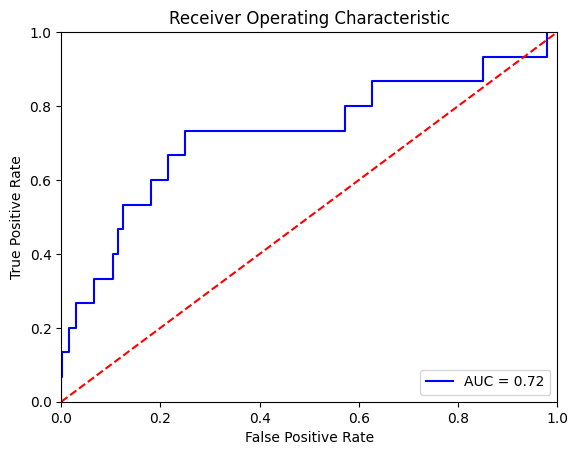

In [322]:
probs = best_cat.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [323]:
predicciones = best_cat.predict(X_test)
mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)


Matriz de confusión
[[2091    0]
 [  14    1]]

El accuracy de test es: 99.335232668566 %
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2091
           1       1.00      0.07      0.12        15

    accuracy                           0.99      2106
   macro avg       1.00      0.53      0.56      2106
weighted avg       0.99      0.99      0.99      2106



In [252]:
#Rango umbrales en pasos pequeños
thresholds = np.arange(0.1, 1.0, 0.1)
precisions = []
recalls = []
f1_scores = []

# Metricas por umbral
for threshold in thresholds:
    y_pred_adjusted = (preds >= threshold).astype(int)  # Aplicar el umbral
    precisions.append(precision_score(y_test, y_pred_adjusted))
    recalls.append(recall_score(y_test, y_pred_adjusted))
    f1_scores.append(f1_score(y_test, y_pred_adjusted))

# resultados
for i, threshold in enumerate(thresholds):
    print(f"Umbral: {threshold:.1f}, Precision: {precisions[i]:.4f}, Recall: {recalls[i]:.4f}, F1-score: {f1_scores[i]:.4f}")


Umbral: 0.1, Precision: 0.6667, Recall: 0.8000, F1-score: 0.7273
Umbral: 0.2, Precision: 0.7857, Recall: 0.7333, F1-score: 0.7586
Umbral: 0.3, Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Umbral: 0.4, Precision: 1.0000, Recall: 0.5333, F1-score: 0.6957
Umbral: 0.5, Precision: 1.0000, Recall: 0.3333, F1-score: 0.5000
Umbral: 0.6, Precision: 1.0000, Recall: 0.2667, F1-score: 0.4211
Umbral: 0.7, Precision: 1.0000, Recall: 0.2667, F1-score: 0.4211
Umbral: 0.8, Precision: 1.0000, Recall: 0.2667, F1-score: 0.4211
Umbral: 0.9, Precision: 1.0000, Recall: 0.2000, F1-score: 0.3333


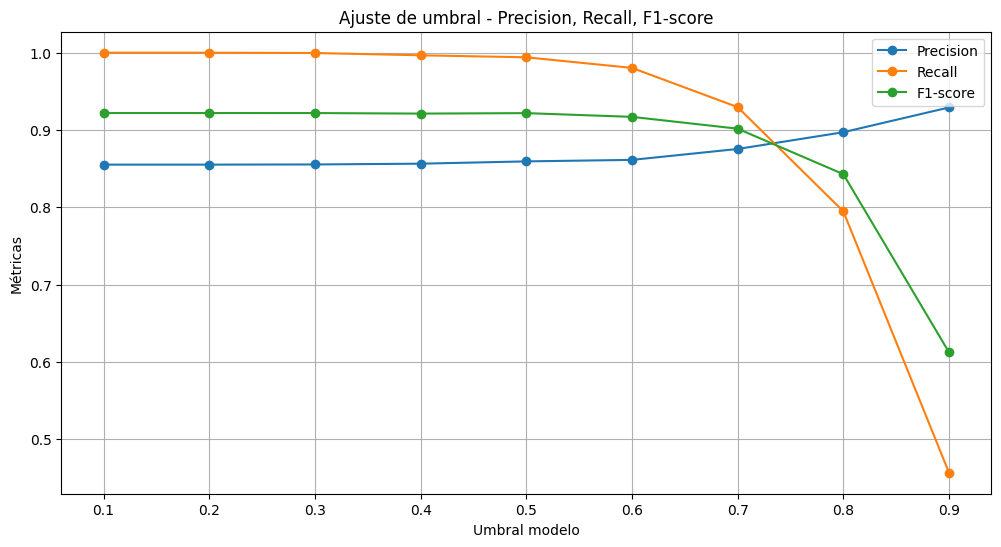

In [438]:
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1-score', marker='o')
plt.xlabel('Umbral modelo')
plt.ylabel('Métricas')
plt.title('Ajuste de umbral - Precision, Recall, F1-score')
plt.legend()
plt.grid(True)
plt.show()


In [439]:
# Coste de un falso positivo (enviar un avión innecesariamente)
cost_fp = 4208.61*2  # Coste de enviar un avión segun los datos que tenemos en la introducción de coste hora.
# pongo un *2 porque en la comunidad valenciana tienen 2 y suponemos que mandamos todas las unidades

# Estimación del coste de un falso negativo (no enviar un avión cuando es necesario)
cost_fn = (6343*0.07) # Un valor extraido de las hectarias mediana (medias muy altas) quemadas en los datos obtenidos 
#y el coste medio de perdida medio ambiental segúnhttps://evenor-tech.com/el-coste-economico-de-los-incendios-forestales/

thresholds = np.arange(0.1, 1.0, 0.05)
total_costs = []

for threshold in thresholds:
    # Utilizo umbral del for
    y_pred_adjusted = (preds >= threshold).astype(int)
    
    # Calculoo FP y FN
    false_positive = ((y_pred_adjusted == 1) & (y_test == 0)).sum()
    false_negative = ((y_pred_adjusted == 0) & (y_test == 1)).sum()

    # Coste total
    total_cost = (false_positive * cost_fp) + (false_negative * cost_fn)
    total_costs.append(total_cost)


for i, threshold in enumerate(thresholds):
    print(f"Umbral: {threshold:.2f}, Coste total: {total_costs[i]:.2f} €")

Umbral: 0.10, Coste total: 3847557.56 €
Umbral: 0.15, Coste total: 3799718.30 €
Umbral: 0.20, Coste total: 3630504.85 €
Umbral: 0.25, Coste total: 3497199.30 €
Umbral: 0.30, Coste total: 3328911.81 €
Umbral: 0.35, Coste total: 3115893.13 €
Umbral: 0.40, Coste total: 2877641.76 €
Umbral: 0.45, Coste total: 2584484.91 €
Umbral: 0.50, Coste total: 2448185.11 €
Umbral: 0.55, Coste total: 2228157.12 €
Umbral: 0.60, Coste total: 2041798.01 €
Umbral: 0.65, Coste total: 1855476.84 €
Umbral: 0.70, Coste total: 1719658.99 €
Umbral: 0.75, Coste total: 1619324.00 €
Umbral: 0.80, Coste total: 1501729.53 €
Umbral: 0.85, Coste total: 1335001.71 €
Umbral: 0.90, Coste total: 1219240.19 €
Umbral: 0.95, Coste total: 1200933.23 €


In [440]:
# Ajuste umbral
threshold = 0.2
y_pred_adjusted = (preds  >= threshold).astype(int)

In [441]:
print(confusion_matrix(y_test, y_pred_adjusted))

print(classification_report(y_test, y_pred_adjusted))



[[  27  430]
 [  25 2676]]
              precision    recall  f1-score   support

           0       0.52      0.06      0.11       457
           1       0.86      0.99      0.92      2701

    accuracy                           0.86      3158
   macro avg       0.69      0.52      0.51      3158
weighted avg       0.81      0.86      0.80      3158



In [748]:
filename = '../Modelos/buldozzer/best_cat_Buldozzer.pkl'

In [749]:
model_and_threshold = {
    'model': best_cat,
    'threshold': threshold}

    
joblib.dump(model_and_threshold, filename)

['../Modelos/buldozzer/best_cat_Buldozzer.pkl']

### Ejemplo uso practico

Lo hago con el mejor de todos que ha sido el best_light_gbm

In [ ]:

def aviondescarga(data):
    """
    Función para predecir si se debe enviar un avión basado en las características dadas.

    Args:
        data (dict): dar un diccionario con las siguientes claves:
            ['Slope', 'TEMPMAX', 'V_VIENTO', 'H_RELAT', 'DifficultyIndex',
            'Elevation', 'TOT_EST', 'ENP_1', 'EIMP_GLOB', 'SHAPE_AREA',
            'BOMBEROS', 'GUARCIVIL', 'F_EJERCIT', 'OPERCIV', 'VOLUN_ORG', 'TECNICOS']

   
    """
    # Asegurarse de que los datos están en el orden correcto
    features = ['COMARCA','difficulty_viento_humedad','D_APIE','DULLUVIA',
             'EROSION','ESTACION','fire_risk_landcover',
             'fire_risk_fuel', 'FuelLoadIndex','Humidity (%)','IND_PEL',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO', 'X', 'Y'] 

    try:
        # ordeanar
        input_data = np.array([data[feature] for feature in features]).reshape(1, -1)

        # P.modelo
        probability = best_model.predict_proba(input_data)[0, 1]  

        # Metemos recomendación un umbral de probabilidad del 80%
        recommendation = "Si, enviar" if probability >= 0.8 else "No, no enviar"

        return {
            "probability": probability,
            "recommendation": recommendation
        }

    except KeyError as e:
        return {"error": f"Falta la característica requerida: {e}"}
    except Exception as e:
        return {"error": f"Ocurrió un error: {e}"}


In [ ]:
# Carga el modelo con joblib
best_model = load('./Modelos/Aviones_descarga/best_light_gbm.pkl')

data = {
    'Slope': 11,
    'TEMPMAX': 18,
    'V_VIENTO': 5,
    'H_RELAT': 82,
    'DifficultyIndex': 0,
    'Elevation': 500.0,
    'TOT_EST': 10,
    'ENP_1': 0,
    'EIMP_GLOB': 3,
    'SHAPE_AREA': 214534.97,
    'BOMBEROS': 4,
    'GUARCIVIL': 14
    

}

In [ ]:
result = aviondescarga(data)
print(result)


{'probability': 0.6927540949712792, 'recommendation': 'No, no enviar'}


## 5. Modelos Regresión

una vez que sabemos si necesitamos o no Helicopteros de descarga lo siguiente que tenemos que saber en cada situcion cuantos necesitaríamos


In [259]:
muestra = data_filtrado.sample(frac=0.2, random_state=42)

In [280]:
# Preparar las características y la variable objetivo
X = data_filtrado[['COMARCA','difficulty_viento_humedad','D_APIE','DULLUVIA',
             'EROSION','ESTACION','fire_risk_landcover',
             'fire_risk_fuel', 'FuelLoadIndex','Humidity (%)','IND_PEL',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO', 'X', 'Y']]
y = data_filtrado[ 'BULDOZZER']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest

Va a ser el primer modelo que usamos para poder hacer un aprendizaje supervisado para ello pasaremos de una primera configuracion donde no vamos a ajustar el modelo si no que lo dejamos de fabrica y luego vamos a intentar ajustar los hiperparametros para poder mejorar las metricas de este y que el test y train mejore a la par y no que haya un sobre ajuste que suele producirse 

Pruebo a hacer el random Forest con los datos predeterminados 

In [281]:
# Modelo de Random Forest Regressor
forest = RandomForestRegressor(random_state=123)


In [282]:
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=123)

Como no hemos aplicado el cross validation se produce un sobreajuste de los datos por lo tanto a partir de ahora es cuando se juega con lo parametros para conseguir mejores valores

In [283]:
# Preparar las características y la variable objetivo
X = data_filtrado[['COMARCA','difficulty_viento_humedad','D_APIE','DULLUVIA',
             'EROSION','ESTACION','fire_risk_landcover',
             'fire_risk_fuel', 'FuelLoadIndex','Humidity (%)','IND_PEL',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO', 'X', 'Y']]
y = data_filtrado[ 'BULDOZZER']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [284]:

# Evaluar el modelo inicial
y_pred = forest.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE del modelo inicial: {mse}")
print(f"MAE del modelo inicial: {mae}")
print(f"R2 del modelo inicial: {r2}")



MSE del modelo inicial: 0.1690801044634378
MAE del modelo inicial: 0.03304368471035138
R2 del modelo inicial: 0.5275326081245145


In [285]:
# Hiperparametros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [ None, 10, 2, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [5, 7, 9]
}



In [286]:
combinaciones = ParameterGrid(param_grid)

In [287]:
# Preparar las características y la variable objetivo
X = balanced_df[['COMARCA','difficulty_viento_humedad','D_APIE','DULLUVIA',
             'EROSION','ESTACION','fire_risk_landcover',
             'fire_risk_fuel', 'FuelLoadIndex','Humidity (%)','IND_PEL',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO', 'X', 'Y']]
y = balanced_df[ 'BULDOZZER_CLASS']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [288]:
# Diccionario para almacenar los resultados
resultados = {'params': [], 'mse': [], 'mae': [], 'r2': []}

# Entreno del modelo por parametros

for params in combinaciones:
    modelo = RandomForestRegressor(
        random_state=123,
        **params
    )

    # Entrenar el modelo
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Guardar los resultados
    resultados['params'].append(params)
    resultados['mse'].append(mse)
    resultados['mae'].append(mae)
    resultados['r2'].append(r2)

In [289]:

resultados_df = pd.DataFrame(resultados)
resultados_df = pd.concat([resultados_df, resultados_df['params'].apply(pd.Series)], axis=1)
resultados_df = resultados_df.drop(columns='params')
resultados_df = resultados_df.sort_values('mse', ascending=True)  # Ordenar por menor MSE

resultados_df.head()


mse       mae        r2  max_depth  max_features  min_samples_leaf  \
246  0.003763  0.016798  0.984946       30.0           5.0               1.0   
3    0.003766  0.016806  0.984936        NaN           5.0               1.0   
5    0.003932  0.017372  0.984271        NaN           5.0               1.0   
247  0.003939  0.017260  0.984245       30.0           5.0               1.0   
4    0.003942  0.017266  0.984233        NaN           5.0               1.0   

     min_samples_split  n_estimators  
246                5.0          50.0  
3                  5.0          50.0  
5                  5.0         200.0  
247                5.0         100.0  
4                  5.0         100.0

In [290]:

# mejor modelo
mejores_params = resultados_df.iloc[0].drop(['mse', 'mae', 'r2']).to_dict()
for key, value in mejores_params.items():
    if isinstance(value, float) and value.is_integer():
        mejores_params[key] = int(value)
        
modelo_final = RandomForestRegressor(random_state=123, **mejores_params)
modelo_final.fit(X_train, y_train)



RandomForestRegressor(max_depth=30, max_features=5, min_samples_split=5,
                      n_estimators=50, random_state=123)

In [295]:
# Preparar las características y la variable objetivo
X = data_filtrado[['COMARCA','difficulty_viento_humedad','D_APIE','DULLUVIA',
             'EROSION','ESTACION','fire_risk_landcover',
             'fire_risk_fuel', 'FuelLoadIndex','Humidity (%)','IND_PEL',
             'MOD_COM','Slope','Temperature (C)','V_VIENTO', 'X', 'Y']]
y = data_filtrado[ 'BULDOZZER']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [296]:
# modelo final
y_pred_final = modelo_final.predict(X_test)
mse_final = mean_squared_error(y_test, y_pred_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)


print(f"MSE del modelo final: {mse_final}")
print(f"MAE del modelo final: {mae_final}")
print(f"R2 del modelo final: {r2_final}")

MSE del modelo final: 0.32553157470554084
MAE del modelo final: 0.036876923830627524
R2 del modelo final: 0.09035392092802197


Importancia de las características en el modelo Random Forest:
                           Importancia
COMARCA                       0.049668
difficulty_viento_humedad     0.044751
D_APIE                        0.017041
DULLUVIA                      0.021940
EROSION                       0.024823
ESTACION                      0.030993
fire_risk_landcover           0.073038
fire_risk_fuel                0.126295
FuelLoadIndex                 0.032880
Humidity (%)                  0.235227
IND_PEL                       0.045247
MOD_COM                       0.085971
Slope                         0.030644
Temperature (C)               0.032754
V_VIENTO                      0.018216
X                             0.043089
Y                             0.087424


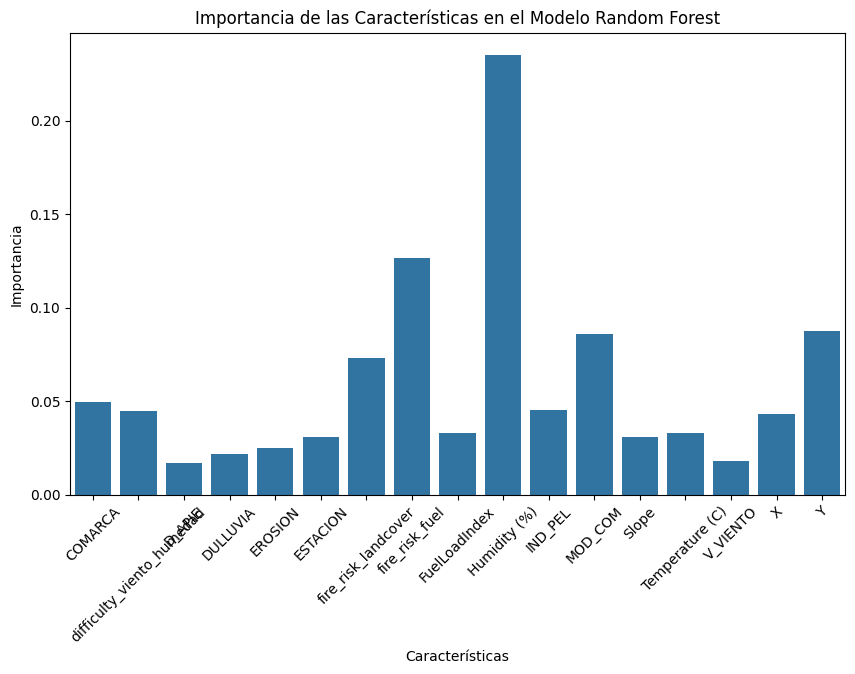

In [297]:

# Importancia de las características en el modelo Random Forest
feature_importances = forest.feature_importances_
feature_importance_df = pd.DataFrame(feature_importances, index=X.columns, columns=['Importancia'])
print('Importancia de las características en el modelo Random Forest:')
print(feature_importance_df)

# Graficar la importancia de las características en el modelo Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df.index, y=feature_importance_df['Importancia'])
plt.title('Importancia de las Características en el Modelo Random Forest')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation = 45)
plt.show()


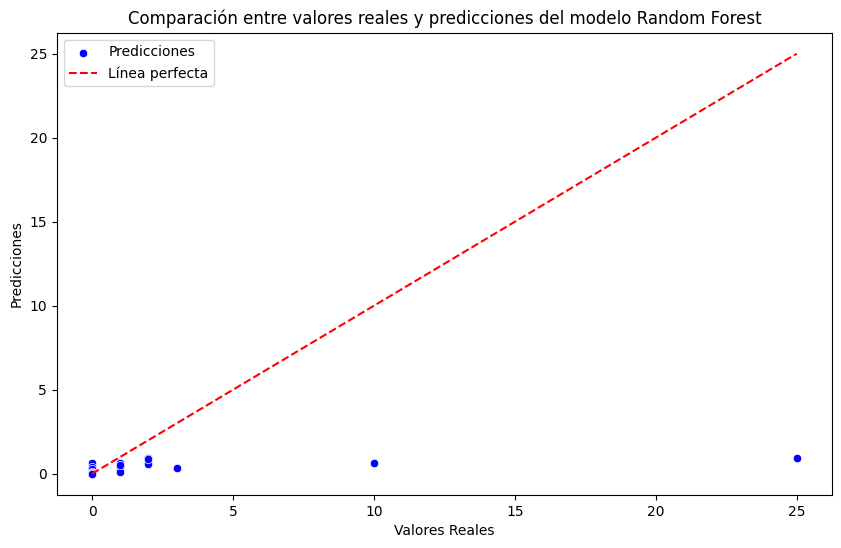

In [298]:
# Crear un DataFrame con las predicciones y los valores reales
predictions_df = pd.DataFrame({'Real': y_test, 'Predicción': y_pred_final})

# Graficar la comparación entre los valores reales y las predicciones
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Real', y='Predicción', data=predictions_df, color='blue', label='Predicciones')
plt.plot([predictions_df['Real'].min(), predictions_df['Real'].max()],
         [predictions_df['Real'].min(), predictions_df['Real'].max()],
         color='red', linestyle='--', label='Línea perfecta')

# Etiquetas y título
plt.title('Comparación entre valores reales y predicciones del modelo Random Forest')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.legend()

# Mostrar gráfico
plt.show()


In [299]:
filename = '../Modelos/buldozzer/regresion_buldozzer.pkl'
joblib.dump(modelo_final, filename)
    

['../Modelos/buldozzer/regresion_buldozzer.pkl']